#Практическая работа
##Набор данных - рукописные цифры
MNIST содержит коллекцию из  70 000 изображений 28 x 28  рукописных цифр от  0 до 9. (60 тыс. в обучающей выборке и 10 тыс. в тестовой)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Из ячейки выше можно заметить, что всё импортировалось верно и данных действительно 70 тыс.
Ниже мы нормализуем наши изображения.

In [2]:
x_train = x_train/255
x_test = x_test/255

In [3]:
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Добавим *ImageDataGenerator*  
*ImageDataGenerator* может быть использован, например, для расширения обучающего или тестового наборов данных, или для создания набора данных на основе имеющихся изображений.

In [4]:
data_gen = ImageDataGenerator(
            rotation_range=12,
            width_shift_range=0.12,
            height_shift_range=0.12,
            shear_range=0.12,
            validation_split=0.2,)

In [5]:
training_generator = data_gen.flow(x_train,y_train,batch_size=32,subset='training')
validation_generator = data_gen.flow(x_test,y_test,batch_size=32,subset='validation')

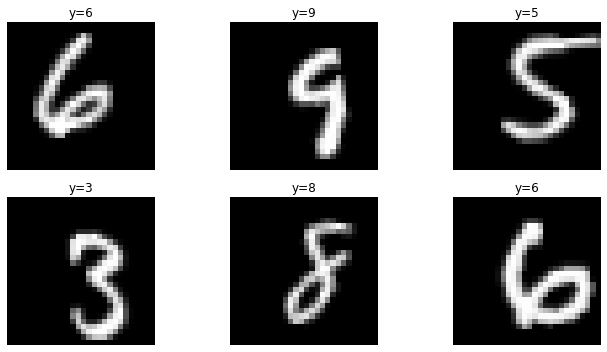

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in training_generator:
        plt.imshow((x[0]/255).reshape(28,28),cmap='gray')
        plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

Далее строим свёрточную модель.
В библиотеке Keras есть несколько различных форматов (планов) для построения моделей, но наиболее часто используется Sequential — поэтому мы и используем его для нашей модели.

1) Первый слой нашей модели - это сверточный слой. Он будет принимать входные данные и пропускать их через сверточные фильтры.

При реализации этого в Keras, мы должны указать количество каналов (фильтров), которое нам нужно (а это 32), размер фильтра (3 x 3 в нашем случае), форму входа при создании первого слоя (которая равна 28 x 28 x 1), функцию активации и отступы.

relu является наиболее распространенной функцией активации, а отступы мы определим через padding = 'same', то есть, мы не меняем размер изображения.

2) Слой нормализаци. Нормализация нормализует входные данные, поступающие в следующий слой, гарантируя, что сеть всегда создает функции активации с тем же распределением, которое нам нужно

3)Этот слой укрупняет масштаб полученных признаков.

4) Откидываем 30% соединений для предотвращения переобучения.

5, 6, 7, 8, 9,10,11,12,13,14,15,16 - повторяем примерно то же самое

17) Сжимаем данные при помощи Flatten

18) Теперь мы используем импортированную функцию Dense и создаем первый плотно связанный слой. Нам нужно указать количество нейронов в плотном слое. 

19) Нормализуем

20) Откидываем 50% соединений

21) Повторяем создание плотносвязанного слоя, на выходи получится ветор из 10 нейронов, каждый из которых хранит некоторую вероятность того, что рассматриваемое изображение принадлежит его классу




In [9]:
    
    model = tf.keras.Sequential([
    
    layers.Conv2D(32,(3,3),input_shape=(28,28,1),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.3),
    
    layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.3),
    
    layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.3),
    
    layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10,activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 64)         

Компилируем модель. 

Оптимизатор - это то, что настроит веса в вашей сети так, чтобы приблизиться к точке с наименьшими потерями. Алгоритм Адама является одним из наиболее часто используемых оптимизаторов, потому что он дает высокую производительность в большинстве задач.

Метрику оценки точности выбираем *accuracy*.


In [10]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
           )

Для скорости обучим модель на 10 эпохах

In [11]:
history_cnn = model.fit_generator(training_generator,epochs=10,validation_data=validation_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1500/1500 [==============================] - 164s 109ms/step - loss: 1.3687 - accuracy: 0.5904 - val_loss: 0.1127 - val_accuracy: 0.9640
Epoch 2/10
1500/1500 [==============================] - 162s 108ms/step - loss: 0.2228 - accuracy: 0.9318 - val_loss: 0.0797 - val_accuracy: 0.9745
Epoch 3/10
1500/1500 [==============================] - 162s 108ms/step - loss: 0.1601 - accuracy: 0.9523 - val_loss: 0.0530 - val_accuracy: 0.9835
Epoch 4/10
1500/1500 [==============================] - 162s 108ms/step - loss: 0.1367 - accuracy: 0.9571 - val_loss: 0.0635 - val_accuracy: 0.9810
Epoch 5/10
1500/1500 [==============================] - 163s 109ms/step - loss: 0.1211 - accuracy: 0.9627 - val_loss: 0.0600 - val_accuracy: 0.9795
Epoch 6/10
1500/1500 [==============================] - 163s 109ms/step - loss: 0.1045 - accuracy: 0.9695 - val_loss: 0.0504 - val_accuracy: 0.9845
Epoch 7/10
1500/1500 [==============================] - 163s 109ms/step - loss: 0.1041 - accuracy: 0.9700 - val_

Построим график зависимости точности модели от эпохи

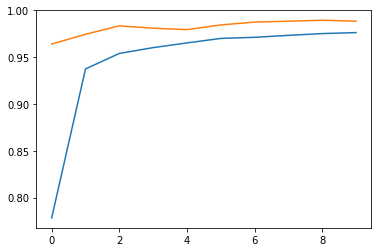

In [12]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])

In [13]:
model.evaluate( x_test, y_test)

313/313 [==============================] - 7s 21ms/step - loss: 0.0185 - accuracy: 0.9938


[0.018528925254940987, 0.9937999844551086]

Видим, что качество модели на тестовой выборке равна 99,4%

In [14]:
model.save("mnist_model.h5")

#Оценка стоимости жилья
Тут сама по себе напрашивается регрессия, но попробуем добавить и нейросеть и посмотрим на результат

Первое, что нужно сделать - скачать данные и разделить их на тестовую и обучающую выборки

Описание данных:

***
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
 prices and the demand for clean air', J. Environ. Economics & Management,
 vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
 ...', Wiley, 1980.   N.B. Various transformations are used in the table on
 pages 244-261 of the latter.

 Variables in order:

 CRIM     per capita crime rate by town

 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.

 INDUS    proportion of non-retail business acres per town

 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

 NOX      nitric oxides concentration (parts per 10 million)

 RM       average number of rooms per dwelling

 AGE      proportion of owner-occupied units built prior to 1940

 DIS      weighted distances to five Boston employment centres

 RAD      index of accessibility to radial highways
 
 TAX      full-value property-tax rate per 10,000 doll.
 
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 
 LSTAT    % lower status of the population
 
 MEDV     Median value of owner-occupied homes in dollars 1000's
***

In [184]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)
x_train.shape, y_train.shape

((404, 13), (404,))

Дальше добавим методы построения моделей

build_model - строит нейросеть

build_model2 - линейную регрессию

In [185]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

def build_model():
  model = tf.keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(x_train.shape[1],)),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

def build_model2():
  model = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
  return model

model = build_model()

model2 = build_model2()
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 64)                896       
_________________________________________________________________
dense_245 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_246 (Dense)            (None, 1)                 65        
_________________________________________________________________
dense_247 (Dense)            (None, 1)                 2         
Total params: 5,123
Trainable params: 5,123
Non-trainable params: 0
_________________________________________________________________


In [188]:
K=model.fit(x_train,y_train, epochs=1000)
K1=model2.fit(x_train,y_train)


Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 5.0161 - mae: 1.6762
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 7.3485 - mae: 1.9705
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 6.2366 - mae: 1.8820
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 7.2495 - mae: 1.9374
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 7.1366 - mae: 1.9980
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 6.5607 - mae: 1.9341
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 5.2104 - mae: 1.6583
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 7.2599 - mae: 1.9523
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 6.1924 - mae: 1.8523
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 5.7640 - mae: 1.8027
Epoch 11/1000
13/13 [============================

Для нейросети мы получаем такие результаты

MAE = 3.198

MSE = 23.62

Это значит, что в среднем модель ошибается на 3.198 тыс. долл.

In [189]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 2ms/step - loss: 23.6207 - mae: 3.1980


[23.620744705200195, 3.1979830265045166]

Регрессия показала себя чуть хуже (на грани погрешности), но она и обучается значительно быстрее.

MAE = 3.46

MSE = 23.179

Можно заметить, что MSE у регрессии ниже, это значит, что на выбросах они не так сильно завышает значения, как нейросеть.

In [192]:
from sklearn import metrics

a = model2.predict(x_test)
b = y_test

print(metrics.mean_squared_error(b,a), metrics.mean_absolute_error(b, a))

23.179863476415978 3.4631856012833397


In [183]:
model.save('house_prices.h5')